In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

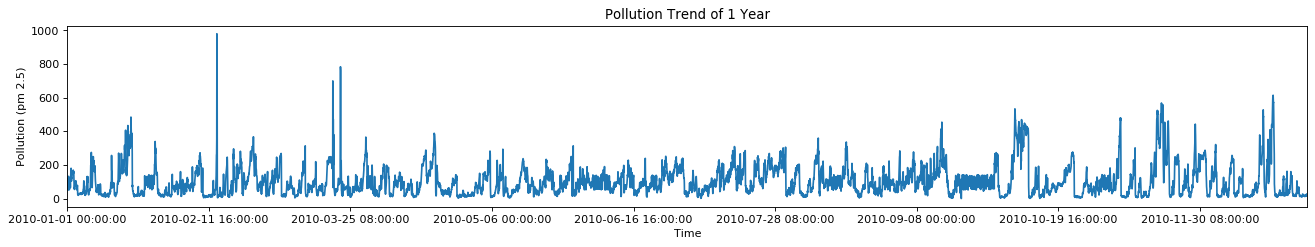

In [3]:
dataset = pd.read_csv('pollution.csv',index_col='date')
fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
dataset['pollution'][:365*24].plot()
plt.title('Pollution Trend of 1 Year')
plt.xlabel('Time')
plt.ylabel('Pollution (pm 2.5)')
plt.show()

In [4]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,month
date,,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,NW,1.79,0,0,1
2010-01-01 01:00:00,95.0,-21,-12.0,1020.0,NW,4.92,0,0,1
2010-01-01 02:00:00,53.0,-21,-11.0,1019.0,NW,6.71,0,0,1
2010-01-01 03:00:00,99.0,-21,-14.0,1019.0,NW,9.84,0,0,1
2010-01-01 04:00:00,118.0,-20,-12.0,1018.0,NW,12.97,0,0,1
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0,12
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0,12
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0,12


In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
#Label Encoder
lbe = LabelEncoder()
#One hot encoder for the wind direction
ohe = OneHotEncoder(categories=[4])
ohe = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [4])],
    remainder='passthrough'
)
ohe_month = OneHotEncoder(categories=[10])
ohe_month = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [10])],
    remainder='passthrough'
)
pol_scaler = MinMaxScaler()
wea_scaler = MinMaxScaler()

In [6]:
import cv2

In [7]:
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray):
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num
    dark_channel = find_dark_channel(img)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break

    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t

    return max_channel.intensity


def find_dark_channel(img):
    return np.unravel_index(np.argmin(img), img.shape)[2]


def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def transmission_map(img, light_intensity, windowSize=20, w=0.95):
    size = img.shape[:2]
    tmap = np.zeros(img.shape, np.float32)

    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])

            sliceimg = img[y_low:y_high, x_low:x_high]

            dark_channel = find_dark_channel(sliceimg)
            tmap[y,x] = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
    return tmap

In [8]:
import os

In [9]:
ltt=os.listdir("Beijing")

In [10]:
np.seterr(divide = 'ignore')
def get_entropy(gray,light_intensity):
    pi=0
    for i in range(1,light_intensity+1):
        p = (gray==i).sum()/gray.size
        pi-= p*max(-20,np.log2(p))
    return pi

In [11]:
import sys
sys.path.append("../dnn_from_scratch")

In [12]:
def gen_dfl(ltt):
    dfl=[]
    for i in range(len(ltt)):
        sys.stderr.write("\r{}/{}".format(i,len(ltt)))
        print("\r{}/{}".format(i,len(ltt)),end="")
        img=cv2.imread("Beijing/"+ltt[i])
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        light_intensity = gray.max()#find_intensity_of_atmospheric_light(img, gray)
        rmscontr=gray.std()
        entr=get_entropy(gray,light_intensity)
        bll=img[:,:,2].mean()
        tm=int(ltt[i][-8:-6])
        mn=int(ltt[i][-6:-4])
        if mn>=30:
            adm=1
        else:
            adm=0
        dfl.append(np.hstack((dataset.iloc[-24*365+i*24+12+tm+adm].values[:-1],np.asarray([rmscontr,entr,bll]))))
    dfl=np.asarray(dfl)
    return dfl

In [13]:
from multiprocessing import Process, Pool

In [14]:
mul=len(ltt)//4+1
pols=Pool().starmap(gen_dfl, [(ltt[i*mul:(i+1)*mul],) for i in range(4)])

In [15]:
dfdt=pd.DataFrame(np.vstack(pols))
dfdt

,0,1,2,3,4,5,6,7,8,9,10
0,43,-16,9,1016,SE,1.79,0,0,62.8937,7.50308,141.887
1,239,-8,0,1017,cv,9.36,0,0,61.9555,7.20637,139.161
2,46,-17,3,1024,cv,1.34,0,0,52.0846,7.00671,146.581
3,221,-8,-3,1021,NW,8.5,0,0,54.7054,7.02694,142.97
4,54,-12,-1,1025,cv,0.89,0,0,56.8386,7.30676,130.73
...,...,...,...,...,...,...,...,...,...,...,...
322,61,-9,10,1022,SE,59.45,0,0,54.0367,6.50628,143.965
323,20,-4,11,1024,NW,8.94,0,0,56.9551,7.34771,159.026
324,18,-14,12,1024,cv,1.78,0,0,51.1679,7.25887,154.773
325,49,-14,14,1016,SE,25.92,0,0,55.3242,7.54275,154.687


In [16]:
# dfdt=pd.DataFrame(dataset.values[:,:-1])
# dfdt

In [17]:
dfdt[4] = lbe.fit_transform(dfdt[4])

In [18]:
ndfdt= pd.DataFrame(ohe.fit_transform(dfdt)[:,1:])

In [19]:
pollution_data=np.array(ndfdt.iloc[:,3])
pollution_data =pol_scaler.fit_transform(pollution_data.reshape(-1,1)).astype(np.float32)

In [20]:
weather_data=np.array(ndfdt.drop(3,axis=1))
weather_data = wea_scaler.fit_transform(weather_data).astype(np.float32)

In [21]:
weather_data.shape,pollution_data.shape

((327, 12), (327, 1))

In [22]:
from tensorflow.keras.models import Sequential,model_from_json
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [23]:
model=Sequential()
model.add(Dense(512,activation='relu', input_shape=(len(weather_data[0]),)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [24]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [25]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [27]:
idxs=np.arange(len(pollution_data))
np.random.shuffle(idxs)

In [28]:
weather_data=weather_data[idxs]
pollution_data=pollution_data[idxs]

In [29]:
cut=323
XDB=weather_data[:cut]
YDB=pollution_data[:cut]
XTB=weather_data[cut:]
YTB=pollution_data[cut:]

In [30]:
model.fit(XDB,YDB,batch_size=16,epochs=70,validation_data=(XTB,YTB))

Train on 323 samples, validate on 4 samples
Epoch 1/70
323/323 [==============================] - 1s 4ms/sample - loss: 0.1676 - accuracy: 0.0093 - val_loss: 0.0839 - val_accuracy: 0.0000e+00
Epoch 2/70
323/323 [==============================] - 0s 324us/sample - loss: 0.1201 - accuracy: 0.0155 - val_loss: 0.0478 - val_accuracy: 0.0000e+00
Epoch 3/70
323/323 [==============================] - 0s 308us/sample - loss: 0.1026 - accuracy: 0.0155 - val_loss: 0.0195 - val_accuracy: 0.0000e+00
Epoch 4/70
323/323 [==============================] - 0s 313us/sample - loss: 0.0819 - accuracy: 0.0124 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 5/70
323/323 [==============================] - 0s 336us/sample - loss: 0.0725 - accuracy: 0.0124 - val_loss: 0.0098 - val_accuracy: 0.0000e+00
Epoch 6/70
323/323 [==============================] - 0s 313us/sample - loss: 0.0563 - accuracy: 0.0155 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 7/70
323/323 [==============================] - 0s 3

323/323 [==============================] - 0s 310us/sample - loss: 0.0282 - accuracy: 0.0124 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 56/70
323/323 [==============================] - 0s 296us/sample - loss: 0.0311 - accuracy: 0.0124 - val_loss: 0.0584 - val_accuracy: 0.0000e+00
Epoch 57/70
323/323 [==============================] - 0s 293us/sample - loss: 0.0257 - accuracy: 0.0124 - val_loss: 0.0314 - val_accuracy: 0.0000e+00
Epoch 58/70
323/323 [==============================] - 0s 273us/sample - loss: 0.0343 - accuracy: 0.0124 - val_loss: 0.0206 - val_accuracy: 0.0000e+00
Epoch 59/70
323/323 [==============================] - 0s 289us/sample - loss: 0.0236 - accuracy: 0.0124 - val_loss: 0.0330 - val_accuracy: 0.0000e+00
Epoch 60/70
323/323 [==============================] - 0s 345us/sample - loss: 0.0290 - accuracy: 0.0124 - val_loss: 0.0416 - val_accuracy: 0.0000e+00
Epoch 61/70
323/323 [==============================] - 0s 302us/sample - loss: 0.0311 - accuracy: 0.0124 -

In [31]:
pred=model.predict(XDB)
pred=pol_scaler.inverse_transform(pred)
lbl=pol_scaler.inverse_transform(YDB)

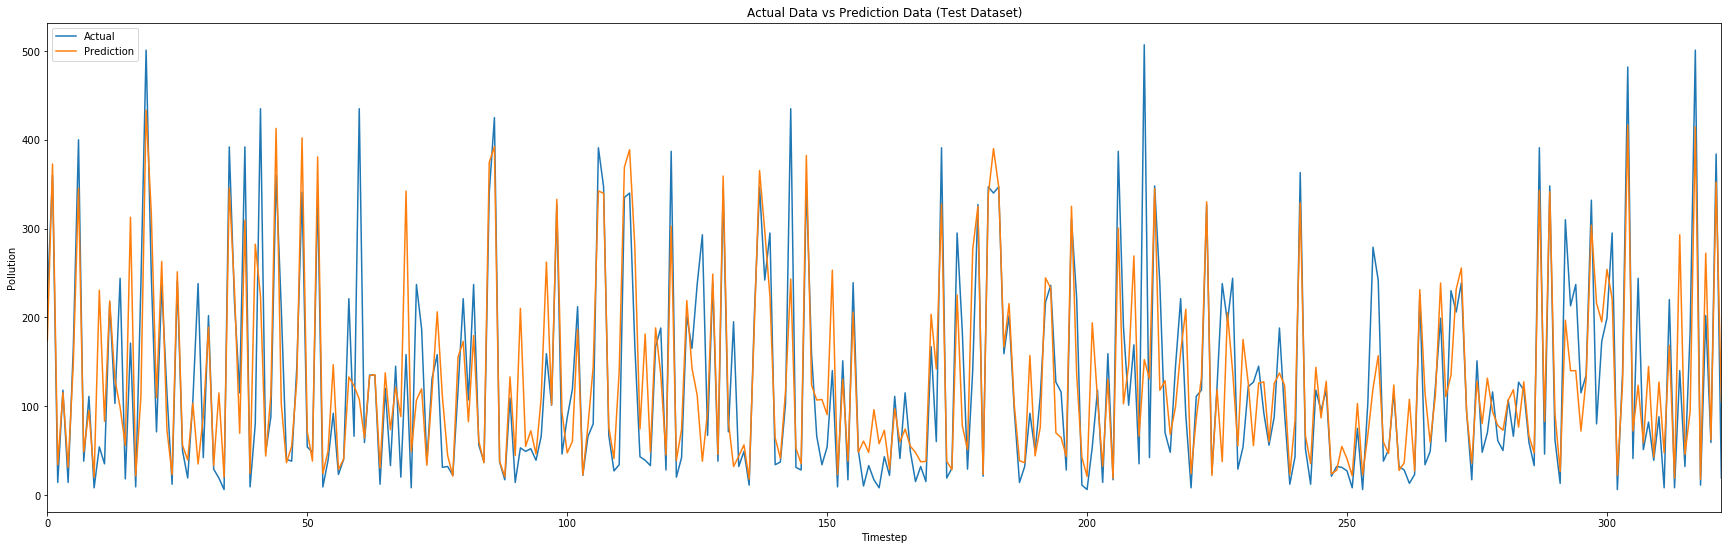

Mean Absolute Error (Test)	=	 42.910667
Root Mean Squared Error (Test)	=	 65.92795769223213
Per cent Error (Test)	=	 8.463642998487664


In [32]:
df = pd.DataFrame(np.hstack((lbl,pred)),columns=['Actual','Prediction'])
df.plot(figsize=(30,9))
plt.title("Actual Data vs Prediction Data (Test Dataset)")
plt.ylabel("Pollution")
plt.xlabel('Timestep')
plt.show()
score_mae = mean_absolute_error(lbl,pred)
score_mse = mean_squared_error(lbl,pred)
print("Mean Absolute Error (Test)\t=\t",score_mae)
print("Root Mean Squared Error (Test)\t=\t",score_mse**0.5)
print("Per cent Error (Test)\t=\t",score_mae*100/lbl.max())

In [47]:
def DetectFifty(filename):
    #Importing the image
    image = cv2.imread(filename)
    image= cv2.resize(image,(512,512))
    #Gray scaling
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    #Extracting images
    minInt, maxInt, minLoc, maxLoc = cv2.minMaxLoc(gray) #Grayscale: MinIntensity, Max, and locations
    beam = cv2.mean(gray)    #Find the mean intensity in the img pls.
    mean = float(beam[0])
    CannyOfTuna = cv2.Canny(gray, (mean + minInt)/2, (mean + maxInt)/2) 
    #Getting coutours
    contours,_ = cv2.findContours(CannyOfTuna,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new = image.copy()
    #Covering the image
    cv2.drawContours(new,contours,-1,(0,0,0),10)
    #Getting contours on covered images
    contours,_ = cv2.findContours(cv2.cvtColor(new,cv2.COLOR_BGR2GRAY),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #Calculating skyline area
    c = max(contours,key = cv2.contourArea)
    cv2.drawContours(image,[c],-1,(0,0,255),3)
    img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    #Returing boolean values
    return cv2.contourArea(c)>(0.5*image.shape[0]*image.shape[1])

In [52]:
import requests, json

def degToCompass(num):
    val=int((num/90))
    arr=["NE","SE","SW","cv"]
    return (arr[(val % 4)])


def get_weather_data(city_name):
    # Enter your API key here
    api_key = "1a3c41d37ba5f4b0e0538917ed9797d3"

    # base_url variable to store url
    base_url = "http://api.openweathermap.org/data/2.5/weather?"

    # complete_url variable to store
    # complete url address
    complete_url = base_url + "appid=" + api_key + "&q=" + city_name

    # get method of requests module
    # return response object
    response = requests.get(complete_url)

    # json method of response object  
    # convert json format data into
    # python format data
    x = response.json()

    # Now x contains list of nested dictionaries
    # Check the value of "cod" key is equal to
    # "404", means city is found otherwise,
    # city is not found
    if x["cod"] != "404":

        # store the value of "main"
        # key in variable y
        y = x["main"]

        # store the value corresponding
        # to the "temp" key of y
        current_temperature = y["temp"]

        # store the value corresponding
        # to the "pressure" key of y
        current_pressure = y["pressure"]

        # store the value corresponding
        # to the "humidity" key of y
        current_humidiy = y["humidity"]

        # store the value of "weather"
        # key in variable z
        wind_speed = x["wind"]["speed"]

        return [-1,0,current_temperature-273,current_pressure,degToCompass(x["wind"]["deg"]),wind_speed,0,0,11,22,33]
    else:
        return None

In [35]:
wdt=[get_weather_data("New Delhi")]

In [40]:
wd=pd.DataFrame(wdt)
wd

,0,1,2,3,4,5,6,7,8,9,10
0,-1,0,12.07,1022,cv,2.6,0,0,11,22,33


In [41]:
wd[4] = lbe.transform(wd[4])

In [44]:
wd= pd.DataFrame(ohe.transform(wd)[:,1:])
wea_dat=np.array(wd.drop(3,axis=1))

In [45]:
imgnm="images/test2.jpg"

True


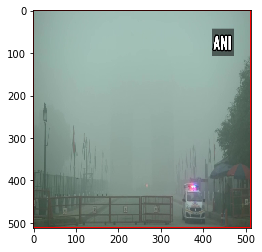

In [48]:
isfifty=DetectFifty(imgnm)
print(isfifty)

In [49]:
if isfifty:
    img=cv2.imread(imgnm)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    light_intensity = gray.max()#find_intensity_of_atmospheric_light(img, gray)
    rmscontr=gray.std()
    entr=get_entropy(gray,light_intensity)
    bll=img[:,:,2].mean()
    wea_dat[0][-3:]=[rmscontr,entr,bll]
    wea_data = wea_scaler.transform(wea_dat).astype(np.float32)
    aqi=pol_scaler.inverse_transform(model.predict(wea_data))[0][0]
    print("PM2.5:",aqi)

PM2.5: 252.52826


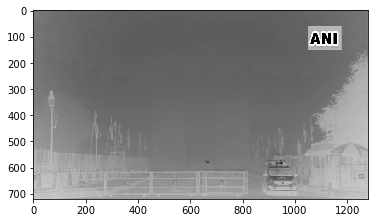

In [50]:
tmap=transmission_map(img,light_intensity,20,1)
plt.imshow(tmap)
plt.show()

In [ ]:
wdt=[get_weather_data("Aurangabad")]

In [ ]:
wd=pd.DataFrame(wdt)
wd

wd[4] = lbe.transform(wd[4])

wd= pd.DataFrame(ohe.transform(wd)[:,1:])
wea_dat=np.array(wd.drop(3,axis=1))

imgnm="images/test.jpg"

isfifty=DetectFifty(imgnm)

if isfifty:
    img=cv2.imread(imgnm)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    light_intensity = gray.max()#find_intensity_of_atmospheric_light(img, gray)
    rmscontr=gray.std()
    entr=get_entropy(gray,light_intensity)
    bll=img[:,:,2].mean()
    wea_dat[0][-3:]=[rmscontr,entr,bll]
    wea_data = wea_scaler.transform(wea_dat).astype(np.float32)
    aqi=pol_scaler.inverse_transform(model.predict(wea_data))[0][0]
    print("PM2.5:",aqi)

In [ ]:
tmap=transmission_map(img,light_intensity,20,1)
plt.imshow(tmap)
plt.show()